In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
from google.colab import files
uploaded = files.upload()

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())


Saving TrainingData.csv to TrainingData.csv
Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%   

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        Root10DaysSeedling  Leaf45DaysOldPlant  Shoot10DaysSeedling  \
count        41110.000000        41110.000000         41110.000000   
mean            -0.522040           -0.585144            -0.545055   
std              0.498568            0.399046             0.477438   
min             -1.000000           -1.000000            -1.000000   
25%             -0.901371           -0.901444            -0.906055   
50%             -0.663664           -0.643376            -0.698864   
75%             -0.378497           -0.451900            -0.250588   
max              1.000000            1.000000             1.000000   

       Shoot35DaysSeedling  Root35DaysSeedling  Leaf21DaysSeedling  \
count         41110.000000        41110.000000        41110.000000   
mean             -0.558906           -0.596196           -0.828778   
std               0.506423            0.461679            0.327542   
min              -1.000000 

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


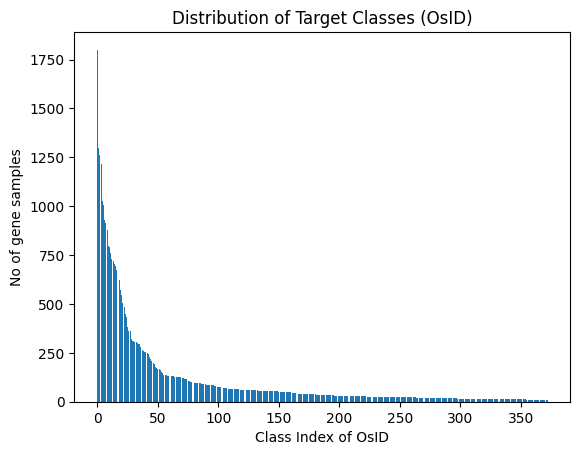

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=40, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/40
1846/1846 [==============================] - 9s 4ms/step - loss: 5.0207 - accuracy: 0.0418 - val_loss: 4.9459 - val_accuracy: 0.0315
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 4.6248 - accuracy: 0.0777 - val_loss: 4.3350 - val_accuracy: 0.1210
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0316 - accuracy: 0.1291 - val_loss: 4.0355 - val_accuracy: 0.1270
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7567 - accuracy: 0.1606 - val_loss: 3.7770 - val_accuracy: 0.1853
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5259 - accuracy: 0.2037 - val_loss: 3.6135 - val_accuracy: 0.1813
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3053 - accuracy: 0.2301 - val_loss: 3.3859 - val_accuracy: 0.2255
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1202 - accuracy: 0.253

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 3ms/step - loss: 5.0023 - accuracy: 0.0416 - val_loss: 4.9013 - val_accuracy: 0.0768
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 4.3681 - accuracy: 0.1018 - val_loss: 4.1825 - val_accuracy: 0.1287
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8556 - accuracy: 0.1425 - val_loss: 3.9035 - val_accuracy: 0.1754
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6027 - accuracy: 0.1948 - val_loss: 3.6881 - val_accuracy: 0.2262
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3758 - accuracy: 0.2214 - val_loss: 3.5670 - val_accuracy: 0.2044
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1869 - accuracy: 0.2462 - val_loss: 3.4015 - val_accuracy: 0.1980
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0318 - accuracy: 0.2740 - val_loss: 3.2885 - val_accuracy: 0.2964
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.9947 - accuracy: 0.0458 - val_loss: 4.6674 - val_accuracy: 0.1072
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 4.2636 - accuracy: 0.1280 - val_loss: 4.1735 - val_accuracy: 0.1604
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8823 - accuracy: 0.1753 - val_loss: 3.9082 - val_accuracy: 0.2178
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6072 - accuracy: 0.2011 - val_loss: 3.6361 - val_accuracy: 0.2147
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3266 - accuracy: 0.2630 - val_loss: 3.3708 - val_accuracy: 0.2502
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0611 - accuracy: 0.2941 - val_loss: 3.1409 - val_accuracy: 0.3208
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8439 - accuracy: 0.3191 - val_loss: 3.0172 - val_accuracy: 0.3375
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.9234 - accuracy: 0.0564 - val_loss: 4.5485 - val_accuracy: 0.1074
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1319 - accuracy: 0.1355 - val_loss: 4.0866 - val_accuracy: 0.1208
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5968 - accuracy: 0.2230 - val_loss: 3.4176 - val_accuracy: 0.2942
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8571 - accuracy: 0.3829 - val_loss: 2.8831 - val_accuracy: 0.3762
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3421 - accuracy: 0.4738 - val_loss: 2.5235 - val_accuracy: 0.4959
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0078 - accuracy: 0.5269 - val_loss: 2.2909 - val_accuracy: 0.5982
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7670 - accuracy: 0.5658 - val_loss: 2.1588 - val_accuracy: 0.5958
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.9642 - accuracy: 0.0518 - val_loss: 4.5545 - val_accuracy: 0.1234
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8904 - accuracy: 0.2282 - val_loss: 3.4997 - val_accuracy: 0.2893
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9982 - accuracy: 0.3848 - val_loss: 2.9170 - val_accuracy: 0.4068
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4038 - accuracy: 0.4835 - val_loss: 2.4432 - val_accuracy: 0.5010
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9838 - accuracy: 0.5469 - val_loss: 2.1183 - val_accuracy: 0.5787
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7092 - accuracy: 0.5920 - val_loss: 1.9381 - val_accuracy: 0.6383
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5328 - accuracy: 0.6235 - val_loss: 1.8508 - val_accuracy: 0.5925
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.8870 - accuracy: 0.0609 - val_loss: 4.3720 - val_accuracy: 0.1410
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7510 - accuracy: 0.2185 - val_loss: 3.4334 - val_accuracy: 0.3056
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7855 - accuracy: 0.3919 - val_loss: 2.7553 - val_accuracy: 0.4328
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1898 - accuracy: 0.4752 - val_loss: 2.3399 - val_accuracy: 0.5481
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8130 - accuracy: 0.5469 - val_loss: 2.1612 - val_accuracy: 0.5509
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5918 - accuracy: 0.5862 - val_loss: 2.0107 - val_accuracy: 0.6051
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4609 - accuracy: 0.6103 - val_loss: 1.9125 - val_accuracy: 0.6229
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7528 - accuracy: 0.0848 - val_loss: 4.0603 - val_accuracy: 0.1446
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3802 - accuracy: 0.2956 - val_loss: 3.1197 - val_accuracy: 0.3828
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5735 - accuracy: 0.4695 - val_loss: 2.5856 - val_accuracy: 0.4733
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0641 - accuracy: 0.5617 - val_loss: 2.2416 - val_accuracy: 0.5848
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7302 - accuracy: 0.6137 - val_loss: 2.0010 - val_accuracy: 0.6114
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5184 - accuracy: 0.6497 - val_loss: 1.8317 - val_accuracy: 0.6532
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3666 - accuracy: 0.6775 - val_loss: 1.7533 - val_accuracy: 0.6673
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/40
1846/1846 [==============================] - 7s 3ms/step - loss: 4.9165 - accuracy: 0.0540 - val_loss: 4.2934 - val_accuracy: 0.2099
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5894 - accuracy: 0.2802 - val_loss: 3.3513 - val_accuracy: 0.3366
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7951 - accuracy: 0.4240 - val_loss: 2.8717 - val_accuracy: 0.5021
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2712 - accuracy: 0.5264 - val_loss: 2.5330 - val_accuracy: 0.5463
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9054 - accuracy: 0.5897 - val_loss: 2.3118 - val_accuracy: 0.6086
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6579 - accuracy: 0.6227 - val_loss: 2.1650 - val_accuracy: 0.6418
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4922 - accuracy: 0.6500 - val_loss: 2.0589 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5977 - accuracy: 0.0777 - val_loss: 4.0525 - val_accuracy: 0.1032
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5865 - accuracy: 0.2159 - val_loss: 3.3547 - val_accuracy: 0.3008
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7697 - accuracy: 0.4285 - val_loss: 2.6013 - val_accuracy: 0.5098
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0306 - accuracy: 0.5639 - val_loss: 2.1066 - val_accuracy: 0.6218
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6021 - accuracy: 0.6395 - val_loss: 1.8324 - val_accuracy: 0.6400
Epoch 6/40
1846/1846 [==============================] - 6s 4ms/step - loss: 1.3442 - accuracy: 0.6818 - val_loss: 1.6874 - val_accuracy: 0.7133
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1749 - accuracy: 0.7157 - val_loss: 1.5213 - val_accuracy: 0.7270
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7816 - accuracy: 0.0639 - val_loss: 4.2468 - val_accuracy: 0.1012
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7429 - accuracy: 0.2173 - val_loss: 3.5988 - val_accuracy: 0.3540
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0302 - accuracy: 0.3954 - val_loss: 3.0542 - val_accuracy: 0.4348
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4365 - accuracy: 0.4904 - val_loss: 2.6659 - val_accuracy: 0.5131
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9874 - accuracy: 0.5598 - val_loss: 2.4539 - val_accuracy: 0.5254
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6848 - accuracy: 0.6093 - val_loss: 2.1649 - val_accuracy: 0.6306
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4898 - accuracy: 0.6479 - val_loss: 2.0505 - val_accuracy: 0.6396
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7569 - accuracy: 0.0680 - val_loss: 4.1034 - val_accuracy: 0.1861
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4824 - accuracy: 0.2922 - val_loss: 3.2148 - val_accuracy: 0.3815
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6699 - accuracy: 0.4290 - val_loss: 2.6405 - val_accuracy: 0.5012
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1243 - accuracy: 0.5104 - val_loss: 2.2395 - val_accuracy: 0.5804
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7558 - accuracy: 0.5858 - val_loss: 1.9723 - val_accuracy: 0.5793
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4993 - accuracy: 0.6405 - val_loss: 1.7977 - val_accuracy: 0.6367
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3205 - accuracy: 0.6796 - val_loss: 1.6786 - val_accuracy: 0.6669
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7174 - accuracy: 0.0767 - val_loss: 4.1096 - val_accuracy: 0.1133
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4837 - accuracy: 0.2945 - val_loss: 3.3382 - val_accuracy: 0.4075
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7656 - accuracy: 0.4447 - val_loss: 2.8870 - val_accuracy: 0.4774
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2708 - accuracy: 0.5099 - val_loss: 2.5960 - val_accuracy: 0.5164
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9328 - accuracy: 0.5675 - val_loss: 2.3773 - val_accuracy: 0.6132
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6836 - accuracy: 0.6198 - val_loss: 2.2014 - val_accuracy: 0.6238
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4863 - accuracy: 0.6614 - val_loss: 2.0980 - val_accuracy: 0.6396
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5605 - accuracy: 0.0675 - val_loss: 4.0210 - val_accuracy: 0.0642
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4704 - accuracy: 0.2564 - val_loss: 3.1079 - val_accuracy: 0.4059
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4947 - accuracy: 0.4835 - val_loss: 2.4440 - val_accuracy: 0.5287
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9185 - accuracy: 0.5829 - val_loss: 2.0762 - val_accuracy: 0.6207
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5650 - accuracy: 0.6494 - val_loss: 1.7750 - val_accuracy: 0.6937
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3268 - accuracy: 0.6938 - val_loss: 1.6568 - val_accuracy: 0.6924
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1670 - accuracy: 0.7195 - val_loss: 1.5152 - val_accuracy: 0.7133
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.8680 - accuracy: 0.0553 - val_loss: 4.2514 - val_accuracy: 0.0763
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7848 - accuracy: 0.1923 - val_loss: 3.5905 - val_accuracy: 0.3254
Epoch 3/40
1846/1846 [==============================] - 6s 4ms/step - loss: 3.0303 - accuracy: 0.4167 - val_loss: 2.9416 - val_accuracy: 0.4451
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3247 - accuracy: 0.5306 - val_loss: 2.4538 - val_accuracy: 0.5864
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8069 - accuracy: 0.6075 - val_loss: 2.1562 - val_accuracy: 0.6147
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4997 - accuracy: 0.6590 - val_loss: 2.0111 - val_accuracy: 0.6706
Epoch 7/40
1846/1846 [==============================] - 6s 4ms/step - loss: 1.3074 - accuracy: 0.6872 - val_loss: 1.8544 - val_accuracy: 0.6928
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 3ms/step - loss: 4.6093 - accuracy: 0.0774 - val_loss: 4.1120 - val_accuracy: 0.1072
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6557 - accuracy: 0.2038 - val_loss: 3.4435 - val_accuracy: 0.2482
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8250 - accuracy: 0.4010 - val_loss: 2.7076 - val_accuracy: 0.5149
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1665 - accuracy: 0.5507 - val_loss: 2.2276 - val_accuracy: 0.5817
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7222 - accuracy: 0.6315 - val_loss: 1.8945 - val_accuracy: 0.6570
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4110 - accuracy: 0.6865 - val_loss: 1.6665 - val_accuracy: 0.7131
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2048 - accuracy: 0.7207 - val_loss: 1.5501 - val_accuracy: 0.7149
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.4879 - accuracy: 0.0950 - val_loss: 3.9817 - val_accuracy: 0.1472
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5340 - accuracy: 0.2170 - val_loss: 3.3082 - val_accuracy: 0.3074
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7254 - accuracy: 0.4333 - val_loss: 2.6189 - val_accuracy: 0.5047
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0495 - accuracy: 0.5758 - val_loss: 2.1533 - val_accuracy: 0.6255
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6115 - accuracy: 0.6499 - val_loss: 1.9585 - val_accuracy: 0.6625
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3337 - accuracy: 0.6991 - val_loss: 1.6836 - val_accuracy: 0.6964
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1614 - accuracy: 0.7228 - val_loss: 1.5889 - val_accuracy: 0.7118
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5448 - accuracy: 0.0878 - val_loss: 4.0410 - val_accuracy: 0.1617
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5360 - accuracy: 0.2213 - val_loss: 3.3391 - val_accuracy: 0.3883
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8432 - accuracy: 0.4057 - val_loss: 2.8141 - val_accuracy: 0.4700
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3172 - accuracy: 0.5198 - val_loss: 2.4243 - val_accuracy: 0.5512
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9214 - accuracy: 0.5848 - val_loss: 2.1136 - val_accuracy: 0.6103
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6061 - accuracy: 0.6407 - val_loss: 1.8684 - val_accuracy: 0.6376
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3874 - accuracy: 0.6801 - val_loss: 1.6991 - val_accuracy: 0.6882
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5333 - accuracy: 0.0769 - val_loss: 4.0931 - val_accuracy: 0.1267
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5526 - accuracy: 0.2415 - val_loss: 3.2918 - val_accuracy: 0.3655
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7043 - accuracy: 0.4492 - val_loss: 2.6244 - val_accuracy: 0.5164
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0420 - accuracy: 0.5469 - val_loss: 2.1769 - val_accuracy: 0.5855
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6132 - accuracy: 0.6240 - val_loss: 1.9352 - val_accuracy: 0.6334
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3660 - accuracy: 0.6740 - val_loss: 1.7838 - val_accuracy: 0.7162
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2012 - accuracy: 0.7141 - val_loss: 1.6072 - val_accuracy: 0.7338
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.6907 - accuracy: 0.0641 - val_loss: 4.1963 - val_accuracy: 0.1274
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5883 - accuracy: 0.2405 - val_loss: 3.2433 - val_accuracy: 0.3556
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6552 - accuracy: 0.4608 - val_loss: 2.5829 - val_accuracy: 0.5054
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0431 - accuracy: 0.5675 - val_loss: 2.1265 - val_accuracy: 0.5936
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6157 - accuracy: 0.6366 - val_loss: 1.8263 - val_accuracy: 0.6735
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3306 - accuracy: 0.6889 - val_loss: 1.6327 - val_accuracy: 0.6805
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1362 - accuracy: 0.7283 - val_loss: 1.4899 - val_accuracy: 0.7309
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7684 - accuracy: 0.0528 - val_loss: 4.2412 - val_accuracy: 0.1014
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7767 - accuracy: 0.1626 - val_loss: 3.5820 - val_accuracy: 0.2244
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0498 - accuracy: 0.3406 - val_loss: 2.9658 - val_accuracy: 0.3879
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3578 - accuracy: 0.5022 - val_loss: 2.4492 - val_accuracy: 0.5404
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8063 - accuracy: 0.6044 - val_loss: 2.1374 - val_accuracy: 0.6240
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4583 - accuracy: 0.6754 - val_loss: 1.9249 - val_accuracy: 0.6849
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2424 - accuracy: 0.7103 - val_loss: 1.7862 - val_accuracy: 0.7364
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.3521 - accuracy: 0.1069 - val_loss: 3.8109 - val_accuracy: 0.1503
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3803 - accuracy: 0.2346 - val_loss: 3.2766 - val_accuracy: 0.3091
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8161 - accuracy: 0.3425 - val_loss: 2.6691 - val_accuracy: 0.4306
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1814 - accuracy: 0.5054 - val_loss: 2.1606 - val_accuracy: 0.5395
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7352 - accuracy: 0.5883 - val_loss: 1.8499 - val_accuracy: 0.6018
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4338 - accuracy: 0.6426 - val_loss: 1.6196 - val_accuracy: 0.6770
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2176 - accuracy: 0.7003 - val_loss: 1.4952 - val_accuracy: 0.7184
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.4183 - accuracy: 0.0999 - val_loss: 4.0241 - val_accuracy: 0.1725
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5949 - accuracy: 0.1887 - val_loss: 3.4835 - val_accuracy: 0.2106
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0389 - accuracy: 0.2663 - val_loss: 2.9643 - val_accuracy: 0.4147
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3813 - accuracy: 0.4377 - val_loss: 2.2849 - val_accuracy: 0.5558
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7403 - accuracy: 0.5803 - val_loss: 1.8528 - val_accuracy: 0.6090
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3610 - accuracy: 0.6636 - val_loss: 1.5361 - val_accuracy: 0.6788
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1493 - accuracy: 0.7078 - val_loss: 1.3788 - val_accuracy: 0.7239
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5584 - accuracy: 0.0735 - val_loss: 4.1178 - val_accuracy: 0.1032
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6546 - accuracy: 0.1914 - val_loss: 3.4685 - val_accuracy: 0.2988
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8972 - accuracy: 0.3772 - val_loss: 2.7321 - val_accuracy: 0.4559
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2098 - accuracy: 0.5151 - val_loss: 2.2539 - val_accuracy: 0.5494
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7277 - accuracy: 0.6173 - val_loss: 1.8684 - val_accuracy: 0.6620
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4088 - accuracy: 0.6707 - val_loss: 1.6378 - val_accuracy: 0.6706
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2190 - accuracy: 0.7089 - val_loss: 1.5069 - val_accuracy: 0.7120
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5624 - accuracy: 0.0794 - val_loss: 4.2273 - val_accuracy: 0.1124
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7665 - accuracy: 0.1567 - val_loss: 3.6110 - val_accuracy: 0.2220
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1534 - accuracy: 0.2639 - val_loss: 3.0461 - val_accuracy: 0.3683
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4191 - accuracy: 0.4748 - val_loss: 2.4875 - val_accuracy: 0.5331
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8939 - accuracy: 0.5709 - val_loss: 2.1423 - val_accuracy: 0.5848
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5619 - accuracy: 0.6411 - val_loss: 1.9250 - val_accuracy: 0.6535
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3487 - accuracy: 0.6881 - val_loss: 1.7836 - val_accuracy: 0.6968
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5160 - accuracy: 0.0936 - val_loss: 4.0221 - val_accuracy: 0.1197
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5550 - accuracy: 0.2188 - val_loss: 3.4084 - val_accuracy: 0.2524
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8128 - accuracy: 0.3946 - val_loss: 2.6518 - val_accuracy: 0.4418
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1280 - accuracy: 0.5414 - val_loss: 2.1189 - val_accuracy: 0.5765
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5885 - accuracy: 0.6412 - val_loss: 1.7008 - val_accuracy: 0.6607
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2764 - accuracy: 0.6947 - val_loss: 1.4919 - val_accuracy: 0.7017
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1005 - accuracy: 0.7277 - val_loss: 1.3409 - val_accuracy: 0.7184
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5493 - accuracy: 0.0881 - val_loss: 4.0889 - val_accuracy: 0.1410
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5701 - accuracy: 0.1987 - val_loss: 3.4060 - val_accuracy: 0.2750
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7831 - accuracy: 0.4045 - val_loss: 2.7039 - val_accuracy: 0.4992
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0845 - accuracy: 0.5526 - val_loss: 2.3143 - val_accuracy: 0.5668
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6603 - accuracy: 0.6271 - val_loss: 2.0453 - val_accuracy: 0.6607
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3814 - accuracy: 0.6799 - val_loss: 1.8912 - val_accuracy: 0.6851
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2171 - accuracy: 0.7065 - val_loss: 1.8014 - val_accuracy: 0.7010
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5103 - accuracy: 0.0764 - val_loss: 4.0862 - val_accuracy: 0.1459
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6379 - accuracy: 0.1794 - val_loss: 3.4886 - val_accuracy: 0.1956
Epoch 3/40
1846/1846 [==============================] - 6s 4ms/step - loss: 2.9868 - accuracy: 0.3324 - val_loss: 2.8801 - val_accuracy: 0.4187
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3252 - accuracy: 0.4944 - val_loss: 2.3426 - val_accuracy: 0.5569
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8466 - accuracy: 0.5912 - val_loss: 1.9873 - val_accuracy: 0.6337
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5120 - accuracy: 0.6610 - val_loss: 1.7670 - val_accuracy: 0.6810
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2867 - accuracy: 0.7026 - val_loss: 1.5718 - val_accuracy: 0.7228
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.6362 - accuracy: 0.0663 - val_loss: 4.1921 - val_accuracy: 0.1157
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6771 - accuracy: 0.1844 - val_loss: 3.4535 - val_accuracy: 0.2816
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8702 - accuracy: 0.3612 - val_loss: 2.7888 - val_accuracy: 0.4026
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2426 - accuracy: 0.5074 - val_loss: 2.3414 - val_accuracy: 0.5578
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8045 - accuracy: 0.5889 - val_loss: 2.0497 - val_accuracy: 0.5892
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4779 - accuracy: 0.6614 - val_loss: 1.8240 - val_accuracy: 0.7012
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2407 - accuracy: 0.7091 - val_loss: 1.6628 - val_accuracy: 0.7243
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.6005 - accuracy: 0.0854 - val_loss: 4.1136 - val_accuracy: 0.1153
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7098 - accuracy: 0.1715 - val_loss: 3.5540 - val_accuracy: 0.2205
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9950 - accuracy: 0.3635 - val_loss: 2.8251 - val_accuracy: 0.4561
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3157 - accuracy: 0.5288 - val_loss: 2.3351 - val_accuracy: 0.5388
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8448 - accuracy: 0.6011 - val_loss: 1.9818 - val_accuracy: 0.5903
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5377 - accuracy: 0.6573 - val_loss: 1.7784 - val_accuracy: 0.6416
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3174 - accuracy: 0.6934 - val_loss: 1.6053 - val_accuracy: 0.7045
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.6713 - accuracy: 0.0654 - val_loss: 4.2749 - val_accuracy: 0.0992
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7944 - accuracy: 0.1285 - val_loss: 3.6372 - val_accuracy: 0.1930
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1989 - accuracy: 0.2445 - val_loss: 3.1100 - val_accuracy: 0.3758
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5737 - accuracy: 0.4413 - val_loss: 2.5841 - val_accuracy: 0.4574
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0353 - accuracy: 0.5332 - val_loss: 2.2272 - val_accuracy: 0.5685
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6618 - accuracy: 0.6135 - val_loss: 1.9532 - val_accuracy: 0.6680
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4161 - accuracy: 0.6688 - val_loss: 1.7571 - val_accuracy: 0.7047
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7615 - accuracy: 0.0667 - val_loss: 4.2567 - val_accuracy: 0.1274
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8595 - accuracy: 0.1568 - val_loss: 3.6400 - val_accuracy: 0.2011
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1454 - accuracy: 0.3140 - val_loss: 2.9264 - val_accuracy: 0.4139
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4743 - accuracy: 0.4973 - val_loss: 2.4038 - val_accuracy: 0.5461
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0431 - accuracy: 0.5719 - val_loss: 2.1188 - val_accuracy: 0.5734
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7639 - accuracy: 0.6233 - val_loss: 1.8780 - val_accuracy: 0.6469
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5560 - accuracy: 0.6636 - val_loss: 1.7094 - val_accuracy: 0.6796
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/40
1846/1846 [==============================] - 6s 3ms/step - loss: 4.7796 - accuracy: 0.0600 - val_loss: 4.2545 - val_accuracy: 0.0882
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8751 - accuracy: 0.1571 - val_loss: 3.7477 - val_accuracy: 0.2143
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3576 - accuracy: 0.2383 - val_loss: 3.2403 - val_accuracy: 0.3003
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7609 - accuracy: 0.3822 - val_loss: 2.6897 - val_accuracy: 0.4724
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2348 - accuracy: 0.5189 - val_loss: 2.3740 - val_accuracy: 0.5613
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8711 - accuracy: 0.5961 - val_loss: 2.1468 - val_accuracy: 0.6169
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6242 - accuracy: 0.6482 - val_loss: 1.9537 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.7548 - accuracy: 0.0679 - val_loss: 4.3908 - val_accuracy: 0.1109
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9900 - accuracy: 0.1399 - val_loss: 3.8704 - val_accuracy: 0.1479
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5703 - accuracy: 0.1863 - val_loss: 3.5541 - val_accuracy: 0.1613
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1809 - accuracy: 0.2473 - val_loss: 3.1510 - val_accuracy: 0.2616
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.7790 - accuracy: 0.3421 - val_loss: 2.7689 - val_accuracy: 0.3903
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4369 - accuracy: 0.4124 - val_loss: 2.5088 - val_accuracy: 0.4315
Epoch 7/40
1846/1846 [==============================] - 8s 4ms/step - loss: 2.1485 - accuracy: 0.4776 - val_loss: 2.2631 - val_accuracy: 0.4816
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.6653 - accuracy: 0.0773 - val_loss: 4.1866 - val_accuracy: 0.1272
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7561 - accuracy: 0.1527 - val_loss: 3.5779 - val_accuracy: 0.2130
Epoch 3/40
1846/1846 [==============================] - 6s 4ms/step - loss: 3.1466 - accuracy: 0.2822 - val_loss: 3.0159 - val_accuracy: 0.3287
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5792 - accuracy: 0.4165 - val_loss: 2.5863 - val_accuracy: 0.4792
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2070 - accuracy: 0.4736 - val_loss: 2.3955 - val_accuracy: 0.4777
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9671 - accuracy: 0.5229 - val_loss: 2.1728 - val_accuracy: 0.5492
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7915 - accuracy: 0.5601 - val_loss: 2.0056 - val_accuracy: 0.5793
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 9s 4ms/step - loss: 4.6722 - accuracy: 0.0751 - val_loss: 4.2051 - val_accuracy: 0.1146
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8227 - accuracy: 0.1612 - val_loss: 3.6807 - val_accuracy: 0.1729
Epoch 3/40
1846/1846 [==============================] - 8s 4ms/step - loss: 3.3153 - accuracy: 0.2323 - val_loss: 3.1777 - val_accuracy: 0.2865
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7711 - accuracy: 0.3511 - val_loss: 2.6778 - val_accuracy: 0.4180
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3125 - accuracy: 0.4436 - val_loss: 2.3487 - val_accuracy: 0.4502
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0185 - accuracy: 0.5036 - val_loss: 2.1064 - val_accuracy: 0.5195
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8197 - accuracy: 0.5425 - val_loss: 1.9997 - val_accuracy: 0.5432
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.6970 - accuracy: 0.0735 - val_loss: 4.2280 - val_accuracy: 0.0997
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8249 - accuracy: 0.1560 - val_loss: 3.6796 - val_accuracy: 0.1732
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3340 - accuracy: 0.2101 - val_loss: 3.2889 - val_accuracy: 0.2330
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8714 - accuracy: 0.2986 - val_loss: 2.8620 - val_accuracy: 0.3333
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4682 - accuracy: 0.3824 - val_loss: 2.5324 - val_accuracy: 0.4189
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1480 - accuracy: 0.4514 - val_loss: 2.2938 - val_accuracy: 0.4832
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9165 - accuracy: 0.4979 - val_loss: 2.0578 - val_accuracy: 0.4827
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.8614 - accuracy: 0.0605 - val_loss: 4.4859 - val_accuracy: 0.0719
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0540 - accuracy: 0.1384 - val_loss: 3.8580 - val_accuracy: 0.1740
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5299 - accuracy: 0.1968 - val_loss: 3.4229 - val_accuracy: 0.2290
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0712 - accuracy: 0.2706 - val_loss: 2.9761 - val_accuracy: 0.3432
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5888 - accuracy: 0.4007 - val_loss: 2.5479 - val_accuracy: 0.4431
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2264 - accuracy: 0.4788 - val_loss: 2.2688 - val_accuracy: 0.4970
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9764 - accuracy: 0.5254 - val_loss: 2.0745 - val_accuracy: 0.5261
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.8595 - accuracy: 0.0557 - val_loss: 4.5745 - val_accuracy: 0.0634
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0782 - accuracy: 0.1241 - val_loss: 3.9432 - val_accuracy: 0.1575
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6132 - accuracy: 0.1849 - val_loss: 3.6072 - val_accuracy: 0.2026
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3126 - accuracy: 0.2177 - val_loss: 3.3568 - val_accuracy: 0.2295
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0092 - accuracy: 0.2871 - val_loss: 3.0787 - val_accuracy: 0.3307
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6873 - accuracy: 0.3627 - val_loss: 2.7883 - val_accuracy: 0.3828
Epoch 7/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4074 - accuracy: 0.4150 - val_loss: 2.5882 - val_accuracy: 0.3963
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.8751 - accuracy: 0.0545 - val_loss: 4.5895 - val_accuracy: 0.0495
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1992 - accuracy: 0.1122 - val_loss: 4.0055 - val_accuracy: 0.1230
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7239 - accuracy: 0.1756 - val_loss: 3.6760 - val_accuracy: 0.1919
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4095 - accuracy: 0.2079 - val_loss: 3.4060 - val_accuracy: 0.2271
Epoch 5/40
1846/1846 [==============================] - 6s 4ms/step - loss: 3.1445 - accuracy: 0.2599 - val_loss: 3.1748 - val_accuracy: 0.2900
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8855 - accuracy: 0.3069 - val_loss: 2.9524 - val_accuracy: 0.3239
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6355 - accuracy: 0.3608 - val_loss: 2.6977 - val_accuracy: 0.3778
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/40
1846/1846 [==============================] - 8s 3ms/step - loss: 4.9475 - accuracy: 0.0469 - val_loss: 4.7031 - val_accuracy: 0.0627
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 4.3286 - accuracy: 0.0911 - val_loss: 4.1714 - val_accuracy: 0.1261
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8270 - accuracy: 0.1618 - val_loss: 3.7971 - val_accuracy: 0.1525
Epoch 4/40
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5169 - accuracy: 0.1992 - val_loss: 3.5370 - val_accuracy: 0.2051
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2361 - accuracy: 0.2425 - val_loss: 3.2916 - val_accuracy: 0.2623
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9099 - accuracy: 0.3177 - val_loss: 2.9879 - val_accuracy: 0.3254
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6137 - accuracy: 0.3783 - val_loss: 2.7152 - val_accuracy:

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

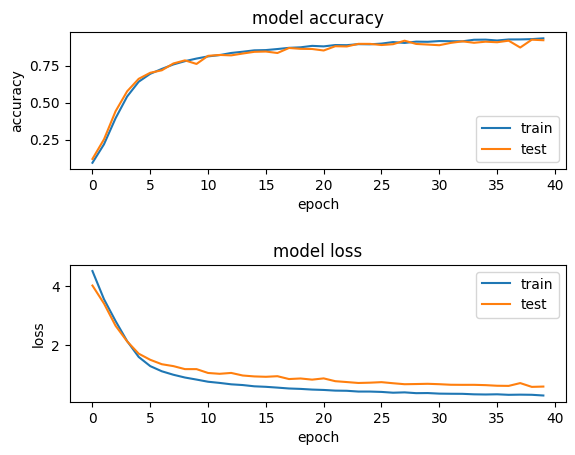

Final Test Accuracy: 0.9324832558631897


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       0.97      1.00      0.99       247
          13       0.94      1.00      0.97       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os04g0475500         328              101       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.404
1,2,0.758
2,3,0.781
3,4,0.826
4,5,0.867
5,6,0.882
6,7,0.867
7,8,0.897
8,9,0.887
9,10,0.894
